# 1. Preliminaries.

Before talking about deep learning and deep learning framework. Let's establish a bit of notation. From here on, we will talk about optimizing models. Think of a model as a set of functions. For example, a model could be a family of functions described as 
$$F(x; w) = x + w \text{ with } x,w \in \mathbb{R}$$
$$\text{or equivantly } F(x; w) = \{f:\mathbb{R}\rightarrow\mathbb{R}\texttt{ }\vert\texttt{ }f(x) = x + w, w \in \mathbb{R}\}$$

However, we will use the first notation. Now, let's make a very important distinction. We call the arguments before ";" **inputs** (such is $x$). Instead, we call the argument after ";" **parameters** (such is $w$).

In python a model could look something like this:

In [1]:
def F(w):
    return lambda x: x + w

print(f"F returns functions. For example F(5) = {F(5)}")
print(f"if F returns functions we can call F(5). For example, F(5)(5) = {F(5)(5)}")

F returns functions. For example F(5) = <function F.<locals>.<lambda> at 0x7f4e9cced1b0>
if F returns functions we can call F(5). For example, F(5)(5) = 10


______

## 1.1 Training/Optimizing

What does it mean to train or optimize a model? It means searching among the family of functions for those who satisfy desired properties. For example, we could want to search for function that are symmetric. Or we could search for functions that interpolate a set of points. Ultimately, this amount to find good parameters. You can search for good parameters any ways you desire. You can even randomly sample parameters until you find good ones.

______

## 1.2 Optimize a constant function.

Let's make a concrete, yet super simple example. This should help you to understand how all blocks fall together. So consider the following model: 

$$F(;w_1) = w_1^2 + 1$$ 

Where $w_1 \in [-10,10]$. $F$ is a model which can be instantiated in infinitely many functions. Each one of these functions has no input and constant real output.  This function is not particularly useful to optimize but it can help you to understand the methodology. 

Now suppose that we want to find in $F$ the function with lowest output. For example, if we set $w_1 = 5$ we get $g(x) = 5^2+1 = 26$ which is not very good. Instead, if we set $w_1 = 2$ we get $s(x)=2^2+1=5$ which is already better. Let's formalize wath we want:

$$\min_{w \in [-10,10]}\{F(;w_1)\} = \min_{w \in [-10, 10]}\{w_1^2 + 1\}$$

______

### 1.1.1 Zeroth Order Optimization (or derivative-free optimization)
Zeroth order optimization tries to optimize models without knowledge of gradients. 0th order optimization is useful when you cannot compute gradients of the model (it may require too much time, too much memory, or you do not know the model at all). These methods are often called black-box optimization, as they require only to be able to query the model. One common kind of zeroth order algorithms are evolutionary ones.

Let's see a super simple example of Zeroth Order optimization that randomly search for the optimal value.

In [2]:
import random

# let's define our model as before
def F(w1):
    return lambda: w1**2 + 1
    
# let's search for good functions by randomly sampling w1.
best_score = float("+inf")
best_param = None
for i in range(10000):
    w1 = random.uniform(-10, 10)
    if F(w1)() < best_score:
        best_score, best_param = F(w1)(), w1
        
print(f"best parameter found w1={best_param} which yield f(w1)={F(best_param)()}")

best parameter found w1=-0.0009051764401668549 which yield f(w1)=1.000000819344388


Which is pretty close to the optimal value ($1$). Unfortunately, randomly searching works only on super simple cases. If we want to tackle real world problems we need to searching more intelligently. 

______

### 1.1.2 First Order Optimization

First-order optimization algorithms require the knowledge of the derivative of $F$. The most used first-order technique is gradient descent. With respect to zeroth-order algorithms, we have more knowledge so usually, we can obtain good results faster. However, computing gradients does require time and memory. Let's compute the derivative of $F$ wrt. $w_1$.

$$\frac{dF(;w_1)}{dw_1} = \frac{d w_1^2 + 1}{d w_1} = 2w_1$$

Now, no matter how we choose $w1$, we can compute the slope of the model. By knowing the slope, we can make small steps towards smaller and smaller functions. Let me visualize a little bit better what I mean.

In [3]:
import matplotlib
%matplotlib widget
%matplotlib inline

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np


@widgets.interact(w1=(-10, 10, 0.25))
def update(w1 = 1.0):
    w = np.linspace(-10, 10,1000)
    y = F(w)() 
    plt.plot(w, y)
    
    plt.scatter(w1, F(w1)())
    
    x = np.linspace(-10,10)
    y = 2*x*w1 - F(w1)() + 2
    plt.plot(x,y)
    
    plt.gca().set_xlim((-5,+5))
    plt.gca().set_ylim((-2,+10))


interactive(children=(FloatSlider(value=1.0, description='w1', max=10.0, min=-10.0, step=0.25), Output()), _do…

The blue line is our model. Remember, each point of our model is actually a function, a constant function. For each of this point we can compute a derivative, the derivative tells us the slope of model. By following the slope we can obtain a function with higher value. By following the negative slope, we can obtain a function with lower value. Step by step, we can obtain incresingly bigger functions of icreasingly smaller functions.   

Just for fun, let's write an algorithm that performs the gradient descent of our model.

In [4]:
import random

def F     (w1): return lambda: w1**2 + 1
def dF_dw1(w1): return 2*w1

param_w1 = random.uniform(-10,10)
learning_rate = 0.001

for i in range(10000):
    param_w1 = param_w1 - learning_rate * dF_dw1(param_w1) # compute a small step in the direction of the slope

print(f"best parameter found w1={param_w1} which yield f(w1)={F(param_w1)()}")

best parameter found w1=1.7981372559086767e-08 which yield f(w1)=1.0000000000000002


______

### 1.1.3 Second Order Optimization

We could go a step beyond and use even the second derivative. There are a lot of reasons to use and to not use the second derivative. However, we will not cover these optimization methods.
______

## 1.2 Optimize a simple function

Now that we have seen how to optimize a model that produced constant functions, we can now try to optimize a model that describes more interesting functions. Consider this model:

$$ F(x;w_1, w_2) = x*w_1 + w_2 $$

Firstly, let's see what kinds of functions does our $F$ describes.

In [5]:
def F(w1, w2):
    return lambda x: x*w1+w2

@widgets.interact(w1=(-10, 10, 0.25), w2=(-10, 10, 0.25))
def plot(w1=7.5, w2=7.5):
    x = np.linspace(-10, 10)
    y = F(w1, w2)(x)
    plt.plot(x, y)
    plt.grid()
    plt.gca().set_xlim((-5,+5))
    plt.gca().set_ylim((-10,+10))


interactive(children=(FloatSlider(value=7.5, description='w1', max=10.0, min=-10.0, step=0.25), FloatSlider(va…

These are all straight lines. No matter which $w_1$ and $w_2$ you will chose. $f$ will always describe a straight line. Let's suppose that we want to find the function with these input-output relation:

| x | y |
|---|---|
| 1 | 2 |
| 2 | 3 |
| 3 | 4 |
| 4 | 5 |

A function from our model is good when fed with $x$s it outputs something close to the described $y$s. Let's define a bit more formally what does this means. So, we derive yet another model from F, which we call L.

$$ L(x; w_1, w_2) = \sum_{(x,y) \in D} (F(x; w1, w2) - y)^2 $$

$L$ is close to $0$ when $F(x_i; w1, w2)$ is similar to $y_i$, for all $i$. In fact $L$ is exactly $0$ when $F(x_i; w1, w2) = y_i$, for all $i$. So, optimizing this model yields exactly the property that we desire. Again, we need to compute the gradients.

Now we need the derivative wrt. $w_1$: 
$$
\begin{align}
\frac{\partial L(x;w_1,w_2)}{\partial w_1} = & \frac{\partial \sum_{(x,y) \in D} (F(x; w1, w2) - y)^2}{d w_1}  \\
= & \sum_{(x,y) \in D} \frac{\partial(F(x; w1, w2) - y)^2}{\partial w_1} \\
= & \sum_{(x,y) \in D} \frac{\partial(x*w_1+w_2 - y)^2}{\partial w_1}  \\
= & \sum_{(x,y) \in D} 2(x*w_1+w_2 - y) \frac{\partial x*w_1+w_2 - y}{\partial w_1}  \\
= & \sum_{(x,y) \in D} 2(x*w_1+w_2 - y)x
\end{align}
$$

And also wrt. $w_2$:

$$
\begin{align}
\frac{\partial L(x;w_1,w_2)}{\partial w_2} = & \frac{d \sum_{(x,y) \in D} (F(x; w1, w2) - y)^2}{\partial w_2} \\
= & \sum_{(x,y) \in D} \frac{\partial(F(x; w1, w2) - y)^2}{\partial w_2} \\
= & \sum_{(x,y) \in D} \frac{\partial(x*w_1+w_2 - y)^2}{\partial w_2} \\
= & \sum_{(x,y) \in D} 2(x*w_1+w_2 - y) \frac{dx*w_1+w_2 - y}{\partial w_2} \\
= & \sum_{(x,y) \in D} 2(x*w_1+w_2 - y)
\end{align}
$$

Now, we have again all the pieces to perform our first order optimization, like we did before.

In [6]:
import numpy as np
import random

x = np.array([1,2,3,4])
y = np.array([2,3,4,5])

def F(w1, w2):
    return lambda x: x*w1+w2

def dF_dw1(w1, w2):
    return (2*(x * w1 + w2 - y)*x).sum()

def dF_dw2(w1, w2):
    return (2*(x * w1 + w2 - y)).sum()

param_w1 = random.uniform(-10,10)
param_w2 = random.uniform(-10,10)
learning_rate = 0.001

for i in range(100000):
    param_w1, param_w2 = (param_w1 - learning_rate * dF_dw1(param_w1, param_w2), 
                          param_w2 - learning_rate * dF_dw2(param_w1, param_w2))

print(f"best parameter found w1={param_w1, param_w2} which yield f(2;w1,w2)={F(param_w1, param_w2)(2)}")

best parameter found w1=(0.9999999999999668, 1.0000000000000968) which yield f(2;w1,w2)=3.00000000000003


_________________________________________
# 2. Automatic Differentiation.

As you have noticed, computing the the gradients by hand is a real pain, and it becomes unmanageble real fast. Fortunately, this work can be done automatically. Again there are many ways to perform differentiation. Let's review few of them. First let's define the gradient of a function $f(x_1, x_2, \dots, x_n)$

$$\nabla f(x_1, x_2, \dots, x_n) = 
\begin{bmatrix}
\frac{\partial f}{\partial x_1}(x_1, x_2, \dots, x_n) \\
\frac{\partial f}{\partial x_2}(x_1, x_2, \dots, x_n) \\
\dots \\
\frac{\partial f}{\partial x_n}(x_1, x_2, \dots, x_n)
\end{bmatrix}$$

There are two main way to compute $\nabla f(x_1, x_2, \dots, x_n)$.
* **Numerical differentiation**. We are only interested in computing the value of the gradient for a particular point in the domain of $f$.
* **Symbolic differentiation**. We are interested in the formula representing the gradients for $f$ for each point in the domain of $f$. 

There are several technique to compute both Numerical differentiation and Symbolic differentiation. Let's review a very simple ones. 
______

# 2.1. Numerical Differentiation.

To get an approximation of the derivative of a function $f$ in a point $(x_0, x_1, \dots, x_n)$, we can use the definition: 

$$\nabla f(x_0, x_1, \dots, x_n) = 
\begin{bmatrix}
\frac{\partial f}{\partial x_1}(x_1, x_2, \dots, x_n) \\
\frac{\partial f}{\partial x_2}(x_1, x_2, \dots, x_n) \\
\dots \\
\frac{\partial f}{\partial x_n}(x_1, x_2, \dots, x_n)
\end{bmatrix} = 
\begin{bmatrix}
\lim_{\epsilon \rightarrow 0} \frac{f(x_0+\epsilon,x_1,\dots,x_n)-f(x_1, x_2, \dots, x_n)}{\epsilon} \\
\lim_{\epsilon \rightarrow 0} \frac{f(x_0,x_1+\epsilon,\dots,x_n)-f(x_1, x_2, \dots, x_n)}{\epsilon} \\
\dots \\
\lim_{\epsilon \rightarrow 0} \frac{f(x_0,x_1,\dots,x_n+\epsilon)-f(x_1, x_2, \dots, x_n)}{\epsilon}
\end{bmatrix}
$$




In [7]:
def f(x): return x**3
def dfdx(f,eps=0.001): return lambda x:(f(x+eps) - f(x))/(eps)

@widgets.interact(x0=(-2, 2, 0.001))
def plot(x0=1):
    x = np.linspace(-10, 10, 1000)
    y = f(x)
    plt.plot(x, y)
    
    plt.scatter(x0, f(x0))
    
    x = np.linspace(-10, 10, 1000)
    y = (x-x0)*dfdx(f)(x0) + f(x0)
    y1 = 3*x**2
    plt.plot(x, y)
    
    plt.gca().set_xlim((-5,+5))
    plt.gca().set_ylim((-10,+10))

    

interactive(children=(FloatSlider(value=1.0, description='x0', max=2.0, min=-2.0, step=0.001), Output()), _dom…

This method is perfectly fine and usable. However, it requires computing $f$ as many times as the number or its arguments. Computing $f$ this way may require too much time.
______

## 2.2. Symbolic Differentiation

Instead of recomputing $f$ with a small changes, we can compute the gradient symbolically ones. We can use the symbolic formula to obtain the numerical gradients in any point of the domain. Moreover, we can also apply optimizations to the symbolic representation of the gradients. But first, we need to talk about how we represent functions. Functions such as 
$$f(x) = x^2 + 5x + 2$$ 
which may look complex, are actually a composition of simpler operations. In this case, there are only three operations: exponentiation ($pow(x,y)=x^y$), multiplication ($mul(x,y)=x*y$) and summation ($sum(x,y)=x+y$). Therefore:

$$f(x) = x^2 + 5x + 2 = sum(sum(pow(x,2),mul(5,x)),2)$$ 

Now, it should be more clear that we can represent $f(x)$ as a tree:





Now, we know how to represent complex composition of functions... as a tree.
______

### 2.2.1 Chain Rule.

Before stepping into the heart of symbolic automatic differentiation, let's see how you can differentiate a composition of functions. Let $f(x) = g(h(x))$ then,  

$$\frac{df(x)}{dx} = \frac{dg(h(x))}{dx} = \frac{dg}{dh}\frac{dh}{dx}$$

Or in the multivariate case. Let $f(x) = g(h_1(x),\dots,h_n(x))$ 

$$\frac{df(x)}{dx} = 
\frac{g(h_1(x),\dots,h_n(x))}{dx} = 
\frac{\partial g}{\partial h_1}\frac{dh_1}{dx} + \dots + \frac{\partial g}{\partial h_n}\frac{dh_n}{dx}$$
______

#### 2.2.1.1 Example 1.

$$\frac{d sum(f(x),g(x))}{dx} = 
\frac{\partial sum}{\partial f}\frac{df}{dx} + \frac{\partial sum}{\partial g}\frac{dg}{dx} = 
\frac{df}{dx} + \frac{dg}{dx}$$
______

#### 2.2.1.2 Example 2.

$$\frac{d mul(f(x),g(x))}{dx} = 
\frac{\partial mul}{\partial f}\frac{df}{dx} + \frac{\partial mul}{\partial g}\frac{dg}{dx} = 
g\frac{df}{dx} + f\frac{dg}{dx}$$
______

#### 2.2.1.3 Example 3.

$$\frac{d pow(f(x),g(x))}{dx} = 
\frac{\partial pow}{\partial f}\frac{df}{dx} + \frac{\partial pow}{\partial g}\frac{dg}{dx} = 
gf^{g-1}\frac{df}{dx} + log(f)f^g\frac{dg}{dx}$$

Now, we have the tools to differentiate the function mentioned before (the one in the tree).

$$
\begin{aligned}
\frac{d sum(sum(pow(x,2),mul(5,x)),2)}{dx} =& \frac{d sum(pow(x,2),mul(5,x))}{dx} + \frac{d2}{dx} \\
= & \frac{d pow(x,2)}{dx} + \frac{d mul(5,x)}{dx} + 0 \\
= & 2x^{2-1}\frac{dx}{dx} + log(x)x^2\frac{d2}{dx} + x\frac{d5}{dx} + 5\frac{dx}{dx} \\
= & 2x + 0 + 0 + 5 \\
= & 2x + 5
\end{aligned}
$$ 

Ok, that was quite a bit of work. At least, it was fairly mechanical. Note that, we only used the knowledge of the derivative of $sum$, $sum$, and $pow$. Given these three pieces, we can derivate any composition of $sum$, $mul$, and $pow$. You can write a differentiation engine in very few lines of code.

In [8]:
class sum:
    def __init__(self, f, g): 
        self.f, self.g = f, g
    def diff(self, var):
        return f"({self.f.diff(var)} + {self.g.diff(var)})"
    def tostr(self):
        return f"({self.f.tostr()} + {self.g.tostr()})"
        
class mul:
    def __init__(self, f, g):
        self.f, self.g = f, g
    def diff(self, var):
        return f"({self.f.tostr()} * {self.g.diff(var)} + {self.g.tostr()} * {self.f.diff(var)})"
    def tostr(self):
        return f"({self.f.tostr()} * {self.g.tostr()})"
                   
class pow:
    def __init__(self, f, g):
        self.f, self.g = f, g
    def diff(self, var):
        return f"({self.g.tostr()} * {self.f.tostr()} ^ ({self.g.tostr()}-1))({self.f.diff(var)}) + (log({self.f.tostr()}) * {self.f.tostr()} ^ {self.g.tostr()})({self.g.diff(var)})"
    def tostr(self):
        return f"({self.f.tostr()}) ^ ({self.g.tostr()})"
                   
class var:
    def __init__(self, name):
        self.name = name
    def diff(self, var):
        if self.name == var.name: return "1"
        return "0"
    def tostr(self):
        return self.name
                   
class const:
    def __init__(self, value):
        self.value = value
    def diff(self, var):
        return "0"
    def tostr(self):
        return self.value


In [9]:
x    = var("x")
two  = const("2")
five = const("5")

f = sum(sum(pow(x, two), mul(five, x)), const(2))

print("     f(x) =", f.tostr())
print("d/dx f(x) =", f.diff(x))

     f(x) = (((x) ^ (2) + (5 * x)) + 2)
d/dx f(x) = (((2 * x ^ (2-1))(1) + (log(x) * x ^ 2)(0) + (5 * 1 + x * 0)) + 0)


In [10]:
x    = var("x")
y    = var("y")
two  = const("2")
five = const("5")

f = sum(sum(pow(x, two), mul(five, y)), const(2))
print("     f(x,y) =", f.tostr())
print("d/dx f(x,y) =", f.diff(x))
print("d/dy f(x,y) =", f.diff(y))


     f(x,y) = (((x) ^ (2) + (5 * y)) + 2)
d/dx f(x,y) = (((2 * x ^ (2-1))(1) + (log(x) * x ^ 2)(0) + (5 * 0 + y * 0)) + 0)
d/dy f(x,y) = (((2 * x ^ (2-1))(0) + (log(x) * x ^ 2)(0) + (5 * 1 + y * 0)) + 0)


We have seen a method for computing derivatives symbolically and a method for computing derivative numerically. In practice, neither of these methods are used in modern automatic differentiation APIs. Usually, much more efficient algorithms are used to perform automatic differentiation. However, this introduction should give you a brief introduction on the main concepts used in automatic differentiation algorithms.

_____________________

# 3.Tensorflow

[Tensorflow] is one of the most famous automatic differentiation libraries. It provides api to access fast, parallel automatic differentiation libraries. [Tensorflow] does provide much more than automatic differentiation. It provides the whole infrastracture to define and train complex models with million of parameters.  
______

## 3.1 Tensorflow: Automatic Differentiation
Before defining complex neural network, let's see how we can use [Tensorflow] to do what we have already done by hand. 


[Tensorflow]: https://www.tensorflow.org/


In [11]:
import tensorflow as tf


x = tf.Variable(10.0) # A variable is what we called a parameter.

for i in range(1000):
    
    with tf.GradientTape() as tape:
        # Here, operations perfomed are registered.
        # Later, these operations will be used to compute gradients.
        y = x**2 + 5*x + 2

    # Now, we can get the derivative of y with respect of x
    dy_dx = tape.gradient(y, x)
    
    # With the derivative, we can, for example, minimize f(x).
    x.assign(x - 0.001*dy_dx)

print(f"x**2 + 5*x + 2 is low for x={x.numpy()}. ({x.numpy()})**2 + 5*({x.numpy()}) + 2={x.numpy()**2 + 5*x.numpy() + 2}")

2022-03-02 18:31:28.451703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 18:31:28.488907: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-03-02 18:31:28.488926: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-03-02 18:31:28.489797: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

x**2 + 5*x + 2 is low for x=-0.8116925954818726. (-0.8116925954818726)**2 + 5*(-0.8116925954818726) + 2=-1.399618107849264


In something like 5 line of code, we obtained the same behavior that we obtained with our custom functions. 

In [12]:
import matplotlib
%matplotlib widget
%matplotlib inline

from IPython.display import clear_output

import ipywidgets        as widgets
import matplotlib.pyplot as plt
import numpy             as np
import tensorflow        as tf

slider = widgets.FloatSlider(description="lr", min=0, max=1,step=0.001)
button = widgets.Button(description="step") 
output = widgets.Output()
display(button, slider, output)

x = tf.Variable(10.0) 

def on_button_clicked(b):
    with output:
        with tf.GradientTape() as tape: y = x**2 + 5*x + 2
        x.assign(x - slider.value*tape.gradient(y, x))
        clear_output(wait=True)
        plt.plot(np.linspace(-10,10,100),
                 np.linspace(-10,10,100)**2 + 5*np.linspace(-10,10,100) + 2)
        plt.scatter([x],[x**2+5*x+2], c="red")
        plt.show()

button.on_click(on_button_clicked)


Button(description='step', style=ButtonStyle())

FloatSlider(value=0.0, description='lr', max=1.0, step=0.001)

Output()

______

## 3.2 Tensorflow: Supervised Learning.

In supervised learning, we have set of couples (input, output) and we are interested to get a predictor that can map input and output correctly. For example, You have a bunch of images of dogs and cat, you can train a model to distinguish dogs from cats. There are a lot of components that are important in any supervised learning enviroment. Let's highlight the main ones. 


1. The **training set**: a set of couples (input, output). We search for functions that are capable of mapping inputs to outputs for the whole training set.  
2. The **test set**: To see wheter our predictors generalizes well, we use another set to test our predictors.
3. The **predictor class**: The set of possible predictors. We search among the predictor class for good ones.
4. The **loss functions**: The loss should be low for good predictor and should be high for bad one. 
5. The **model**: When we combine loss and predictor class, we obtain a model. We can train a model as we have already see.
______

### 3.2.1 Get The Data.

1. Download the dataset.
2. Define loading procedures.


In [13]:
import wget, zipfile, os, random

if not os.path.isfile("data.zip"): 
    print("downloading...")
    wget.download("https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/3362/31148/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1646390400&Signature=mEr6DFSAZ3dCo2el6QcXOhwDIubJ1d%2B%2Fk1tLEHL9hr0LM682fco0IOWdNOfMMQG9no27M%2F%2BD2pU4ZbXh%2BLo1c0Gve%2BsAJgdYHblfmfg41hvyVOMXvrqZ%2BCGDrD3KhRSU%2Bc9xCHAQIfBppYJg0zKitt1zT69ccYkOK17cYs2now6PgJ1o4STlh6B%2BUTAP%2BwmQ4nYzr5hZ3s%2BAE8d%2FxiEVEGP53pkHMYJv60Pl8JSj80p7DCY8EJ7RfLZcbW2G6%2B%2F7TsblvZeDJQmFQEsQlUOLuQUvePPhh%2BysYDBGwyC27gf5fGixl31z92AppMkUH2ooWb9GDrnWt7ey9zeaNQoQxA%3D%3D&response-content-disposition=attachment%3B+filename%3Ddogs-vs-cats.zip", "data.zip")

if not (os.path.isdir("data") and os.path.isdir("data/train") and os.path.isdir("data/test1")): 
    print("extracting...")
    with zipfile.ZipFile("data.zip"      , 'r') as file: file.extractall("./data/")
    with zipfile.ZipFile("data/train.zip", 'r') as file: file.extractall("./data/")
    with zipfile.ZipFile("data/test1.zip", 'r') as file: file.extractall("./data/")

paths = list(map(lambda name:os.path.join("data/train",name), os.listdir("data/train/")))
random.shuffle(paths)
test_paths  = paths[:len(paths)//3]
train_paths = paths[len(paths)//3+1:]

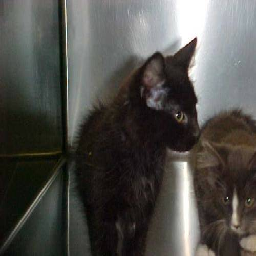

In [14]:
import random, PIL
PIL.Image.open(random.choice(train_paths)).resize((256,256), PIL.Image.NEAREST)

label: 0


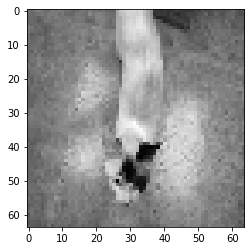

In [15]:
import random, PIL
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def to_standard_image(path, size=(64, 64)):
    return tf.keras.utils.img_to_array(PIL.Image.open(path).resize(size, PIL.Image.NEAREST)).mean(-1)/255

def to_standard_label(path): 
    return 0 if "cat" in path else 1

def load_normalized_batch(paths, batch_size = 10, image_size = (64, 64)):
    batch = random.choices(paths, k=batch_size)
    X = np.stack([to_standard_image(p, size=image_size) for p in batch])
    Y = np.array([to_standard_label(p) for p in batch])
    return X,Y
    
X,Y = load_normalized_batch(train_paths)
plt.imshow(X[0], cmap='gray')
print(f"label: {Y[0]}")

______
### 3.2.2 Define A Model.

In tensorflow you can define a model in many ways. One of the most flexible ways to define a models is extending [tf.keras.Model]. The `__init__` should define which component you are going to use. Instead, the `call` method should define how the pre-defined components interact.   

In `tf.keras.layers` you can find a vast amount of layers. Some very common, some very specific. You can build new layer using the predefined ones. Or, you can define new layers entirily using tensorflow Variables. 
______
#### 3.2.2.1 Dense Layer
For example one of the most common layers is the `tf.keras.layers.Dense`. It computes:

$$g(xW^T + b)$$

Where $x$ is the layer input, $x \in \mathbb{R}^{n}$. $W$ is a matrix of learnable variables, $W \in \mathbb{R}^{m\times n}$. $b$ is a vector of learnable variables, $b \in \mathbb{R}^m$. $g$ is an activation function. Without $g$, the dense layer would be a simple linear layer. Both, $g$ and $m$ are hyper-parameters of choice. Why hyper-parameters? if parameters defines class of functions, hyper-parameters define class of class of functions. Do not think to it too much, it is just a convenient way to say that it is a parameter that you can choose as you like, and it is not trained. Often, you can find a dense layer represented as:


<center><img src="https://slugnet.jarrodkahn.com/_images/tikz-be0593f4dad31d763e7f8371668007610e7907c1.png" alt="drawing" width="400"/></center>

________

### 3.2.2.2 Convolution Layer

[Convolution] is another deep learning layer. It was originally inspired by the structure of the human visual cortex. In practice, convolution layers works extremely well with visual tasks. The Covolution layer is already defined in tensorflow and you can adopt it easily. Below there is a simple gif showing a convolution operation. 

* the **kernel** is the sliding window that you see below. It is composed of trainable parameters. While it slides, it computes the element-wise multiplication between the kernel and the window.
* the kernel is said to become **active** when it produces an high value. In practice, this means that it becomes active when it is multiplied against a window similar to the kernel.

<center><img src="https://theano-pymc.readthedocs.io/en/latest/_images/numerical_no_padding_no_strides.gif" alt="drawing" width="400"/></center>

In modern architectures, convolution layers are stacked on top of each other. Layers closer to the input become become active for simple shapes. The layers on top activates on complex patterns formed by the features below. The figure below shows some activation pattern for low/mid/high-level layers. 

<center><img src="https://d33wubrfki0l68.cloudfront.net/05c47b9b612f8b9f2f57cae4505a4773415f3f22/b9ed6/assets/convnets/cnn20.png" alt="drawing" width="400"/></center>

_________

### 3.2.2.3 Max Pooling Layer
The [MaxPooling2D] layer is another common layer found in neural network for vision. In practice, works similarly to the convolution layer. Instead of having a kernel of trainable parameters, it takes the maximum of each window.
______


[MaxPooling2D]:https://keras.io/api/layers/pooling_layers/max_pooling2d/
[Dense]:https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
[Convolution]:https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

In [16]:
batch_size = 10
image_size = (256,256)

class MyModel(tf.keras.Model):
    def __init__(self, batch_size, image_size):
        super(MyModel, self).__init__()
        self.reshape = tf.keras.layers.Reshape((128*128,))
        
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu') 
        self.maxp1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu') 
        self.maxp2 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.flat1 = tf.keras.layers.Flatten()
        
        self.dense1  = tf.keras.layers.Dense(64, activation="relu")
        self.dense2  = tf.keras.layers.Dense(1 , activation="relu")

    def call(self, x):
        x = tf.expand_dims(x, -1)
        x = self.maxp1(self.conv1(x))
        x = self.maxp2(self.conv2(x))
        x = self.flat1(self.conv3(x))
        x = self.dense2(self.dense1(x))
        return x[:, 0]
        
lossfn = lambda preds, truths: tf.reduce_sum((preds - truths)**2)

______
### 3.2.3. Training Step

Now we can define a training step. We need to do the following things:
1. Feed data to the model.
2. Compute gradients.
3. Update model paramaters (aka tensorflow variables).
4. Compute additional metrics, such as accuracy.

In [17]:
def train_step(X, Y, model):
    
    # register operations
    with tf.GradientTape() as tape:
        X = tf.cast(tf.convert_to_tensor(X), tf.float32)
        Y = tf.cast(tf.convert_to_tensor(Y), tf.float32)
        P = model(X, training=True)
        loss = lossfn(Y, P)
        
    # compute gradients
    gradients = tape.gradient(loss, model.trainable_variables)

    # update parameters
    for v,g in zip(model.trainable_variables, gradients): v.assign(v - 0.0001*g)
        
    # compute accuracy
    acc = tf.reduce_sum(tf.cast(Y == tf.round(P), tf.int32))/X.shape[0]
    
    return loss.numpy(), acc.numpy()

_____
### 3.2.4. Training the model
To train we just need to repeat the train step until we are satisfied.

In [18]:
model = MyModel(batch_size, image_size)
for i in range(1000):
    X,Y = load_normalized_batch(train_paths, batch_size=batch_size, image_size=image_size)
    l,a = train_step(X, Y, model=model)
    print(f"\r batch: {i}, loss: {l}, acc: {a}", end="    ")

 batch: 99, loss: 2.2379167079925537, acc: 0.7    

______
### 3.2.4. Testing the model

To test the model, we collect the metrics on the test set, without performing any training.

In [19]:
import random

tp, fp, fn, tn = 0, 0, 0, 0
random.shuffle(test_paths)
paths = test_paths[:1000]
for i,p in enumerate(paths):
    X = to_standard_image(p, size=image_size)
    Y = to_standard_label(p)
    P = tf.round(model(X.reshape(1,image_size[0],image_size[1]), training=True)).numpy()[0]

    if Y == 1 and P == 1: tp += 1
    if Y == 0 and P == 1: fp += 1
    if Y == 1 and P == 0: fn += 1
    if Y == 0 and P == 0: tn += 1
    acc = (tp + tn) / (tp + tn + fp + fn)
    print(f"\r {i}/{len(paths)}, acc: {acc}",end="")

print(f"\ntest accuracy: {acc}")

 999/1000, acc: 0.51851751751751756
test accuracy: 0.518


We have trained our model for very few training step, still we managed to achieve something around ~60% of accuracy. All considered, which is not particularly good. If you let it run for more time you will obtain better results. However, we can do much better. There are a few things we need to introduce before going any further.

_______
### 3.2.5. Improving the Model.

#### 3.2.5.1 Loss.

All loss have the one thing in common, they are big when there are error and they are small when everithing is right. By minimizing a loss, you are forcing your model do behave the way you want. However, it should be noted that different loss may impact the learning process differently. Ultimatly, using the right loss for your task can lead to improvements and faster convergence. Unfotunatly, knowing the right loss to use is not an easy task. Luckily, tensorflo already defines several losses that you can try out easily. 

______

#### 3.2.5.2 Optimizer.

Up until now to we update the model parameter by simply computing the partial derivatives of $w$ with respect our model $L$.  
$$ w \leftarrow w - \frac{\partial L}{\partial w} $$

This little procedure is called optimizer. It turns out that there are a lot of ways you can define an optimizer. Instead of following blindly the current gradient you can average the current gradient with previous ones. You are still doing gradient descent but with a different optimization procedure. One popular optimizer that is often used is [Adam]. Adam, among many others, is already defined in tensorflow and can be adopted easily.

______

#### 3.2.5.3 Skip-Connections.

You should know that a bigger model means that you can approximate more complex functions. However, in practice, it is not always the case. You will find yourself in many situation in which having more layers does actually hurt the results. Skip-connections are one of those mechanism that can be useful to avoid this issue. given a layer $layer$ woth input $x$ you can define a skip-connection for $x$ as follow:  

$$x = x + layer(x)$$

______

### 3.2.5.4 Pretraining

When we say nothing, tensorflow initialize the parameters randomly. This is perfectly fine for most scenarios. However, it is well known that some initializations are better than others. For example, if we were to train our model on task for which we have many many data available, we can hope that it will learn feature general enough that can be useful for our task of interest. 

* When we train a model on a task with huge dataset available with the intention of reusing its parameter later, we are doing **pretraining**.
* When we train an already trained model on another task (or a different dataset), we are doing **fine-tunig**.

Luckily, tensorflow has some pretrained models already defined so that we can just fine-tune them. Among these, one famous pretrained model is [ResNet]. ResNet relies heavily on both convolutions and skip-connections.
______

Finally, we can put everything toghether and train a much better model. 

[Adam]:https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
[ResNet]:https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50

In [20]:
import tensorflow as tf
import random

class ResNet(tf.keras.Model):
    def __init__(self):
        super(ResNet, self).__init__()
        self.resnet  = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
        self.avg     = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))
        self.dense   = tf.keras.layers.Dense(2, activation="softmax")
        self.squeeze = tf.keras.layers.Reshape((2,))
        
    def call(self, x):
        return self.squeeze(self.dense(self.avg(self.resnet(x))))
    
resnet  = ResNet()
optim   = tf.keras.optimizers.Adam(learning_rate=0.0001)
lossfn  = tf.keras.losses.CategoricalCrossentropy(from_logits=True, axis=-1,)

### TRAIN LOOP ###
for i in range(20):
    batch = random.choices(train_paths, k = 10)                                                # load a
    batchX = [tf.keras.preprocessing.image.load_img(x, target_size=(224,224)) for x in batch ] # batch
    batchY = [[1,0] if "cat" in p else [0, 1]                                 for p in batch ] # worth of
    batchX = [tf.keras.preprocessing.image.img_to_array(x)                    for x in batchX] # images
    batchX = [tf.keras.applications.resnet50.preprocess_input(x)              for x in batchX] # 
    batchX = tf.stack(batchX)                                                                  #
    batchY = tf.convert_to_tensor(batchY)                                                      #

    
    with tf.GradientTape() as tape:            # register the
        batchP = resnet(batchX, training=True) # computational 
        loss   = lossfn(batchY, batchP)        # graph

    # compute gradient and update the parameters
    gradients = tape.gradient(loss, resnet.trainable_variables)
    optim.apply_gradients(zip(gradients, resnet.trainable_variables))
    
    # compute accuracy score
    acc = tf.reduce_sum(tf.cast(tf.argmax(batchY,-1) == tf.argmax(batchP,-1), tf.int32))/batchX.shape[0]

    print(f" train {i}/{20}, loss:{loss.numpy()}, acc:{acc.numpy()}")
    
### TEST LOOP ###
tp,fp,fn,tn = 0,0,0,0
for i,p in enumerate(test_paths[:100]):
    X = tf.keras.preprocessing.image.load_img(p, target_size=(224,224))
    X = tf.keras.preprocessing.image.img_to_array(X)
    X = tf.keras.applications.resnet50.preprocess_input(X)
    X = tf.expand_dims(X,0)
    Y = [1,0] if "cat" in p else [0,1]
    Y = tf.convert_to_tensor(Y)
    Y = tf.expand_dims(Y,0)    
    
    P = resnet(X, training=False)
    
    Y, P = tf.argmax(Y,-1).numpy(), tf.argmax(P,-1).numpy()

    if Y == 1 and P == 1: tp += 1
    if Y == 0 and P == 1: fp += 1
    if Y == 1 and P == 0: fn += 1
    if Y == 0 and P == 0: tn += 1
    
    print(f"\rtest {i}/{100}, acc:{(tp + tn) / (tp + tn + fp + fn)}", end="")

 train 0/20, loss:0.7095881104469299, acc:0.5
 train 1/20, loss:0.7494958639144897, acc:0.6
 train 2/20, loss:0.5074869990348816, acc:0.8
 train 3/20, loss:0.5289326310157776, acc:0.7
 train 4/20, loss:0.5476246476173401, acc:0.7
 train 5/20, loss:0.39856094121932983, acc:0.9
 train 6/20, loss:0.3666684627532959, acc:1.0
 train 7/20, loss:0.44464969635009766, acc:0.9
 train 8/20, loss:0.49842995405197144, acc:0.8
 train 9/20, loss:0.331683486700058, acc:1.0
 train 10/20, loss:0.3283822536468506, acc:1.0
 train 11/20, loss:0.3337506949901581, acc:1.0
 train 12/20, loss:0.3279488682746887, acc:1.0
 train 13/20, loss:0.3446766138076782, acc:1.0
 train 14/20, loss:0.3569696247577667, acc:1.0
 train 15/20, loss:0.35724398493766785, acc:1.0
 train 16/20, loss:0.32425346970558167, acc:1.0
 train 17/20, loss:0.3204311430454254, acc:1.0
 train 18/20, loss:0.33001023530960083, acc:1.0
 train 19/20, loss:0.3241623342037201, acc:1.0
test 99/100, acc:0.9594949494949495

logit: [[0.6691641211509705, 0.33083590865135193]]
label: cat


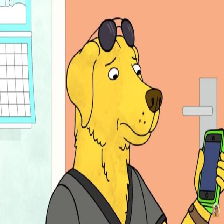

In [21]:
paths = list(map(lambda name:os.path.join("data/test1",name), os.listdir("data/test1/")))
image = tf.keras.preprocessing.image.load_img("samples/dog4.jpg", target_size=(224,224))
X = tf.keras.preprocessing.image.img_to_array(image)
X = tf.keras.applications.resnet50.preprocess_input(X)
X = tf.expand_dims(X,0)

P = resnet(X, training=False)
label2name = {0:"cat", 1:"dog"}

print(f"logit: {P.numpy().tolist()}")
print(f"label: {label2name[tf.argmax(P,-1).numpy()[0]]}")
image